['.ipynb_checkpoints', 'sample_submission.csv', 'test.csv', 'train.csv', 'Untitled.ipynb']
(2.544, 18.18]      22460
(18.18, 33.66]      11380
(33.66, 49.14]       2099
(49.14, 64.62]        274
(64.62, 80.1]         165
(80.1, 95.58]          58
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: income_total, dtype: int64
gender :
0    24430
1    12027
Name: gender, dtype: int64
--------------
Having a car or not : 
0    22614
1    13843
Name: car, dtype: int64
--------------
Having house reality or not: 
1    24506
0    11951
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    25709
1    10748
Name: phone, dtype: int64
--------------
Having a email or not: 
0    33186
1     3271
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    28235
1     8222
Name: work_phone, dtype: int64
--------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 9999
Data columns (tota

C:\Anaconda3\envs\tabnet\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


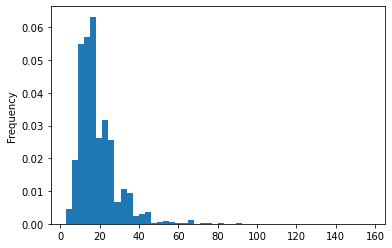

In [1]:
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss

import pandas as pd
import numpy as np
np.random.seed(0)

from tqdm.notebook import tqdm

import os

from matplotlib import pyplot as plt
%matplotlib inline

d = "C:\kaggle_data\credit_card"
lst = os.listdir(d)
print(lst)
train = pd.read_csv(d + '\\' +lst[3])
test = pd.read_csv(d + '\\' +lst[2])
ss = pd.read_csv(d + '\\' +lst[1])
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

data=pd.concat([train, test], axis=0)
data.shape

# 나이 변환
def days_to_age(x):
    return (x*-1)/365
data['DAYS_BIRTH'] = data['DAYS_BIRTH'].apply(days_to_age)

# 마이너스 값 변환
def minus(x):
    return x * -1
data['begin_month'] = data['begin_month'].apply(minus)

data.loc[(data.DAYS_EMPLOYED)>=0,'DAYS_EMPLOYED'] = 0

data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply(days_to_age)

data.loc[data['child_num'] >= 2,'child_num']=2

data['income_total'] = data['income_total'].astype(object)
data['income_total'] = data['income_total']/10000 
print(data['income_total'].value_counts(bins=10,sort=False))
data['income_total'].plot(kind='hist',bins=50,density=True)

count, bin_dividers =np.histogram(data['income_total'], bins=7)
bin_names=[int(i) for i in range(7) ]
data['income_total']=pd.cut(x=data['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

data['gender'] = data['gender'].replace(['F','M'],[0,1])
print('gender :')
print(data['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
data['car'] = data['car'].replace(['N','Y'],[0,1])
print(data['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
data['reality'] = data['reality'].replace(['N','Y'],[0,1])
print(data['reality'].value_counts())
print('--------------')
      
print('Having a phone or not: ')
print(data['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(data['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(data['work_phone'].value_counts())
print('--------------')

from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
data['income_type']=label_encoder.fit_transform(data['income_type'])
data['edu_type']=label_encoder.fit_transform(data['edu_type'])
data['family_type']=label_encoder.fit_transform(data['family_type'])
data['house_type']=label_encoder.fit_transform(data['house_type'])
data['income_total']=label_encoder.fit_transform(data['income_total'])
data['occyp_type']=label_encoder.fit_transform(data['occyp_type'])

data.info()

train=data[:len(data)-10000]
test=data[len(data)-10000:]

train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test.drop('credit', axis=1)

np.random.seed(42)
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train.shape[0],))

train_indices = train_x[train.Set=="train"].index
valid_indices = train_x[train.Set=="valid"].index

In [2]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train_x.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train_x[col].nunique())
        l_enc = LabelEncoder()
        train_x[col] = train_x[col].fillna("NaN")
        train_x[col] = l_enc.fit_transform(train_x[col].values)
        try:
            test_X[col] = test_x[col].fillna("NaN")
            test_x[col] = l_enc.transform(test_x[col].values)
        except:
            print(f"Column {col} does not exist in test set")
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        training_mean = train_x.loc[train_indices, col].mean()
        train.fillna(training_mean, inplace=True)
        test.fillna(training_mean, inplace=True)

features = [ col for col in train_x.columns] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

X_train = train_x[features].values[train_indices]
y_train = train_y.values[train_indices]

X_valid = train_x[features].values[valid_indices]
y_valid = train_y.values[valid_indices]

X_test = test_x[features].values

gender 2
Column gender does not exist in test set
car 2
Column car does not exist in test set
reality 2
Column reality does not exist in test set
child_num 3
Column child_num does not exist in test set
income_total 7
Column income_total does not exist in test set
income_type 5
Column income_type does not exist in test set
edu_type 5
Column edu_type does not exist in test set
family_type 5
Column family_type does not exist in test set
house_type 6
Column house_type does not exist in test set
FLAG_MOBIL 1
Column FLAG_MOBIL does not exist in test set
work_phone 2
Column work_phone does not exist in test set
phone 2
Column phone does not exist in test set
email 2
Column email does not exist in test set
occyp_type 19
Column occyp_type does not exist in test set
family_size 10
Column family_size does not exist in test set
begin_month 61
Column begin_month does not exist in test set


C:\Anaconda3\envs\tabnet\lib\site-packages\pandas\core\frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [7]:
train.columns[cat_idxs]

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'FLAG_MOBIL', 'work_phone',
       'phone', 'email', 'occyp_type', 'family_size', 'begin_month'],
      dtype='object')

In [5]:
len(cat_idxs)

16

In [7]:
cat_idxs=cat_idxs,
cat_dims=cat_dims,
cat_emb_dim=1,

(5295, 1)

In [10]:
import numpy as np
from numpy import linalg as LA

In [11]:
A = np.array([[2,1],[1,2]])
Eig_value, Eig_vector = LA.eig(A)

In [14]:
B = Eig_vector

In [16]:
# 큰 값부터 정렬한 index 반환
index = Eig_value.argsort()[::-1]
P = np.zeros((2,2))
D = np.zeros((2,2))

In [21]:
P_inverse = np.zeros((2,2))
for i in range(0,2):
    # 고유벡터를 transpose한 후 큰 것부터 한 행씩 
    P[i] = B.T[index[i]]
    D[i][i] = Eig_value[index[i]]
P = P.T
P_inverse = np.linalg.inv(P)

In [22]:
print("<행렬 A을 고유분해한 결과> ")
print("행렬 P ")
print(P,"\n")
print("행렬 D ")
print(D, "\n")
print("행렬 P_inverse ")
print(P_inverse, "\n")
print("P * D * P_inverse = A? ")
print(P @ D @ P_inverse)

<행렬 A을 고유분해한 결과> 
행렬 P 
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]] 

행렬 D 
[[3. 0.]
 [0. 1.]] 

행렬 P_inverse 
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]] 

P * D * P_inverse = A? 
[[2. 1.]
 [1. 2.]]
